In [1]:
import os
import pandas as pd
import geopandas as gpd
import sklearn
import contextily as ctx
import datetime
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload 2

from tqdm import tqdm
tqdm.pandas()

from util.isochrones import Isochrones
from util.gtfsdownloader import GtfsDownloader
from util.graphhopper import Graphhopper

import logging
logging.getLogger().setLevel(logging.INFO)
logging.getLogger().addHandler(logging.StreamHandler())

DROOT = os.path.join('./1-data/')
drootf = lambda path: os.path.join(DROOT, path)

In [2]:
pc_gdf = gpd.read_file('./1-data/2023-CBS_pc4_2022_v1/cbs_pc4_2022_v1.gpkg')
pc_gdf.postcode4 = pc_gdf.postcode4.astype(str)
pc_gdf['kmarea'] = pc_gdf.to_crs(pc_gdf.estimate_utm_crs()).area / 10e6 # to Km2
pc_gdf['centroid_utm'] = pc_gdf.to_crs(pc_gdf.estimate_utm_crs()).centroid.to_crs("EPSG:4326")
pc_gdf.head(2)

,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,centroid_utm
0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
1,1217,7735,3790,3945,1145,990,1230,2320,2055,70,0,10,10,10,3505,1405,1040,140,920,2.1,3680,1670,495,345,360,290,295,140,80,1675,70,30,375,330,754,345,2126,2,"MULTIPOLYGON (((140209.617 470877.047, 140206....",0.743158,POINT (5.15649 52.23844)


In [3]:
dt  = datetime.datetime(2023, 10, 3, 8, 30, 0)

gtfs_client        = GtfsDownloader(os.environ.get("TRANSITLAND_KEY"))
bbox = Polygon([(2.525270676284332, 53.90529065617606), 
                (2.563337250331754, 51.316965101673354),
                (6.890703684450792, 50.49093846981179), 
                (7.587110859128601, 53.96129229352274)])
gtfs_client.set_search(bbox.centroid, bbox, 10000)
feed_ids = gtfs_client.search_feeds()
# feeds = gtfs_client.download_feeds(feed_ids, os.path.join(DROOT, 'gtfs'), 'NL', [dt])

Fetching agencies & trips 10000 meters around POINT (5.015915829086381 52.44276817080626).
Fetched 7 relevant feeds ['f-saint~etienne~stas', 'f-germany~long~distance~rail', 'f-germany~regional~rail', 'f-u-nl', 'f-germany~urban~transport', 'f-nvbw~bwsbahnubahn', 'f-u-flixbus']


In [4]:
# graphhopper = Graphhopper(droot=DROOT, city='NL')
# graphhopper.set_osm('1-data/osm/netherlands-latest.osm.pbf')
# graphhopper.set_gtfs(feeds)
# graphhopper.build()
# graphhopper.calibrate(pc_gdf.centroid_utm.sample(20), off_dt=dt, peak_dt=dt)

In [5]:
# Set queries
isochrone_config = [
    ('transit_off',        [30], dt, 'g'),
    ('transit_bike_off',   [30], dt, 'g'),
    ('driving_off',        [25], dt, 'g'),
    ('cycling',            [30], dt, 'g'), 
    ('walking',            [30], dt, 'g')
]

CACHE = drootf('./graphhopper-cache.v1.db')
isochrone_client = Isochrones(graphhopper_url="http://localhost:8989", db=CACHE)
pc_gdf['centroid_nearest'] = pc_gdf.centroid_utm.progress_apply(lambda x: isochrone_client.nearest(x))

100%|██████████| 4070/4070 [00:49<00:00, 82.62it/s] 


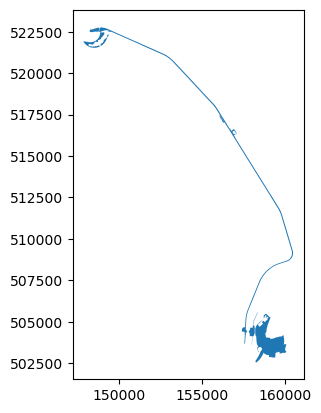

In [6]:
pc_gdf[pc_gdf.centroid_nearest.isna()].plot()
pc_gdf_f = pc_gdf[pc_gdf.centroid_nearest.notna()]

In [8]:
isochrones, stats = isochrone_client.get_isochrones(
    city_id='NL', 
    points=gpd.GeoSeries(pc_gdf_f.centroid_nearest, crs='EPSG:4326'),
    config=isochrone_config
)

Out of total 20345 (4069 origins), 100.0% cached.


In [13]:
pc_gdf_reach = gpd.sjoin_nearest(isochrones.set_geometry("startpt"), pc_gdf_f.set_geometry('centroid_nearest'))
pc_gdf_reach.to_pickle('1-data/pc_gdf_reach.pcl')
pc_gdf_reach.head()

/Users/ivo/mambaforge/envs/thesis-env/lib/python3.11/site-packages/geopandas/array.py:365: UserWarning: Geometry is in a geographic CRS. Results from 'sjoin_nearest' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  warnings.warn(


,uid,pid,startpt,trmode,tt_mnts,dep_dt,source,city_id,isochrone,cache_avail,index_right,postcode4,aantal_inwoners,aantal_mannen,aantal_vrouwen,aantal_inwoners_0_tot_15_jaar,aantal_inwoners_15_tot_25_jaar,aantal_inwoners_25_tot_45_jaar,aantal_inwoners_45_tot_65_jaar,aantal_inwoners_65_jaar_en_ouder,percentage_geb_nederland_herkomst_nederland,percentage_geb_nederland_herkomst_overig_europa,percentage_geb_nederland_herkomst_buiten_europa,percentage_geb_buiten_nederland_herkomst_europa,percentage_geb_buiten_nederland_herkmst_buiten_europa,aantal_part_huishoudens,aantal_eenpersoonshuishoudens,aantal_meerpersoonshuishoudens_zonder_kind,aantal_eenouderhuishoudens,aantal_tweeouderhuishoudens,gemiddelde_huishoudensgrootte,aantal_woningen,aantal_woningen_bouwjaar_voor_1945,aantal_woningen_bouwjaar_45_tot_65,aantal_woningen_bouwjaar_65_tot_75,aantal_woningen_bouwjaar_75_tot_85,aantal_woningen_bouwjaar_85_tot_95,aantal_woningen_bouwjaar_95_tot_05,aantal_woningen_bouwjaar_05_tot_15,aantal_woningen_bouwjaar_15_en_later,aantal_meergezins_woningen,percentage_koopwoningen,percentage_huurwoningen,aantal_huurwoningen_in_bezit_woningcorporaties,aantal_niet_bewoonde_woningen,gemiddelde_woz_waarde_woning,aantal_personen_met_uitkering_onder_aowlft,omgevingsadressendichtheid,stedelijkheid,geometry,kmarea,centroid_utm
0,NL-0-transit_off-30m-g,0,POINT (4.89239 52.29702),transit_off,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.77416 52.78650, 4.77416 52.78650, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
1,NL-0-transit_bike_off-30m-g,0,POINT (4.89239 52.29702),transit_bike_off,30,2023-10-03 08:30:00+02:00,g,NL,"MULTIPOLYGON (((4.90843 52.79254, 4.90843 52.7...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
2,NL-0-driving_off-25m-g,0,POINT (4.89239 52.29702),driving_off,25,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.63366 52.62118, 4.63380 52.62117, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
3,NL-0-cycling-30m-g,0,POINT (4.89239 52.29702),cycling,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.69872 52.78816, 4.69866 52.78819, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)
4,NL-0-walking-30m-g,0,POINT (4.89239 52.29702),walking,30,2023-10-03 08:30:00+02:00,g,NL,"POLYGON ((4.77512 52.78684, 4.77511 52.78684, ...",True,0,1184,625,320,305,100,90,110,215,110,70,10,10,10,10,255,70,70,20,95,2.4,245,165,10,-99997,10,20,10,25,-99997,20,80,20,15,10,902,15,585,4,"MULTIPOLYGON (((121294.892 478995.293, 121341....",0.121549,POINT (4.89281 52.29704)


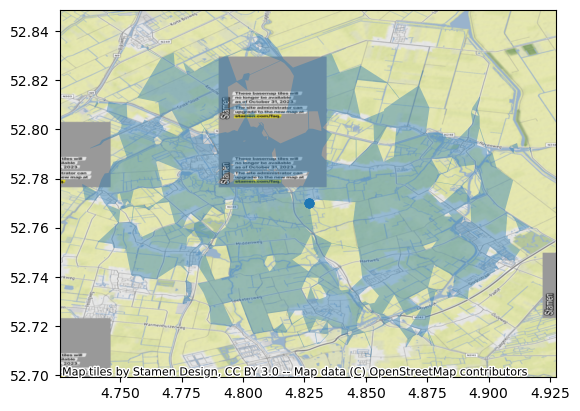

In [20]:
ax = pc_gdf_reach[(pc_gdf_reach.postcode4 == '1769') & 
                  (pc_gdf_reach.trmode == 'transit_bike_off')].isochrone.plot(alpha=0.4)
pc_gdf_reach[(pc_gdf_reach.postcode4 == '1769')].plot(ax=ax)
ctx.add_basemap(ax=ax, crs=pc_gdf_reach.crs)